# IMAGE CLASSIFICATION: FOOD EDITION :)

An attempt to classify images into three food categories: Ice cream, Ramen, Omelette using Transfer Learning.

### Dataset: https://www.kaggle.com/dansbecker/food-101/home

Food101 is a labelled dataset with 101 different food classes comprising 1000 images in each class. With the help of the dataset, food was classified into the above three categories. 

### Model

The model comprises of two parts: the convolution base and the classifier. 
VGG16 was used for the convolution base and the classifier comprises of fully connected layers. 

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import tensorflow as tf
import itertools

from shutil import copyfile
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.applications import VGG16

# 1. Analysis of Data

The test and train images for each class was loaded.
The dataset was divided into two subsets: 
    1. Training data consisting of 750 images in each class.
    2. Test data consisting of 250 images in each class.

In [5]:
path = './Desktop/Images/'
ice_cream_train = glob.glob(path + 'train/ice_cream/*')
ice_cream_test = glob.glob(path + 'test/ice_cream/*')
omelette_train = glob.glob(path + 'train/omelette/*')
omelette_test = glob.glob(path + 'test/omelette/*')
ramen_train = glob.glob(path + 'train/ramen/*')
ramen_test = glob.glob(path + 'test/ramen/*')

In [6]:
print("Analysis by class: \n\t\tTrain\tTest")
print("Ice Cream\t{}\t{}".format(len(ice_cream_train), len(ice_cream_test)))
print("Ramen\t\t{}\t{}".format(len(ramen_train), len(ramen_test)))
print("Omelette\t{}\t{}".format(len(omelette_train), len(omelette_test)))

Analysis by class: 
		Train	Test
Ice Cream	750	250
Ramen		750	250
Omelette	750	250


In [14]:
train_datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5,
                 shear_range=0.2,
                 zoom_range=0.2,
                 width_shift_range=0.05,
                 height_shift_range=0.05,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 horizontal_flip=True,
                 vertical_flip=False,
                 rescale=1/255)
train_gen = train_datagen.flow_from_directory(
        path + 'train/',
        target_size=(228,228),
        class_mode='binary',
        batch_size=32)

test_datagen = ImageDataGenerator(rescale=1/255)
test_gen = test_datagen.flow_from_directory(
        path + 'test/',
        target_size=(228,228),
        class_mode='binary',
        batch_size=32)

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.


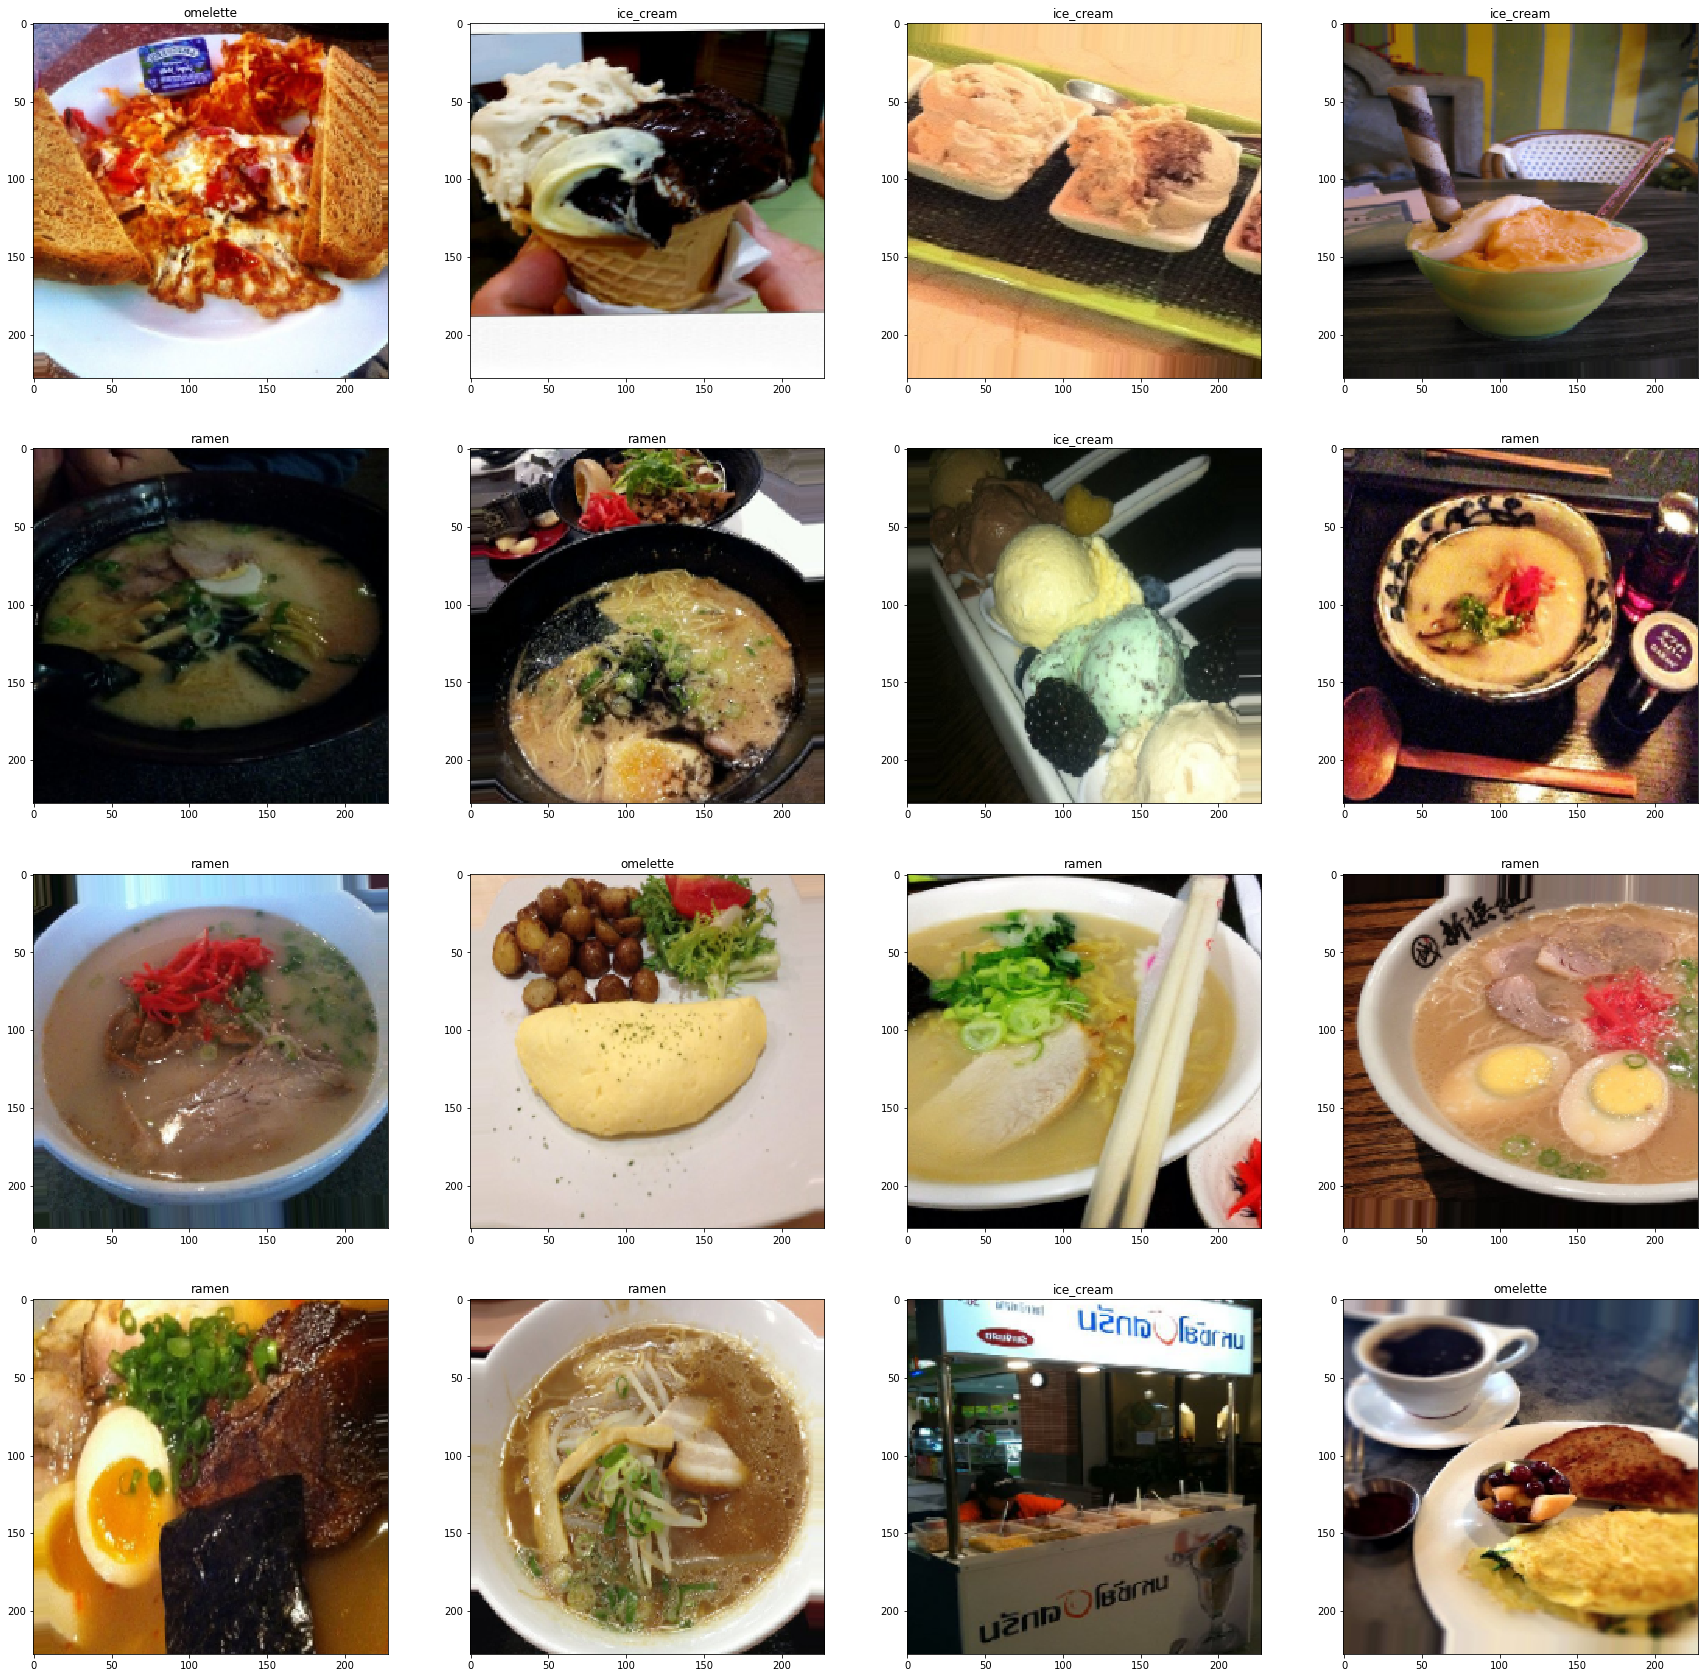

In [8]:
n_row = 4
n_col = 4
x = 0

class_to_category = {
     0 : 'ice_cream',
     1 : 'omelette',
     2 : 'ramen'
} 

for image in train_gen:
    fig, axis = plt.subplots(n_row, n_col, figsize=(30, 30))
    for i in range(n_row):
        for j in range(n_col):
            axis[i,j].imshow(image[0][x])
            label = image[1][x].astype('int')
            axis[i,j].set_title(class_to_category[label])
            x += 1  
    break

# 2. Modelling

The convolution base will be used to extract features from the images which will then be trained in a classifier. 

In [10]:
conv_net = VGG16(weights='imagenet', include_top=False, input_shape=(228, 228, 3))

print(conv_net.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 228, 228, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 228, 228, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 228, 228, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 114, 114, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 114, 114, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 114, 114, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 57, 57, 128)       0     

In [75]:
def extract_features(train_gen, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count))
    batch_size = 32
    
    i = 0
    for input_batch, labels_batch in train_gen:
        features_batch = conv_net.predict(input_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_gen, 2250)
test_features, test_labels = extract_features(test_gen, 750)

In [18]:
print(train_features, train_labels)

[[[[1.61310025e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    5.58190167e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 8.65257740e-01 ... 0.00000000e+00
    7.58671820e-01 0.00000000e+00]
   [7.55329430e-02 0.00000000e+00 8.34313035e-01 ... 4.67507280e-02
    9.75113153e-01 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 6.13372564e-01 ... 3.55170853e-03
    7.60963321e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 7.66613334e-02 ... 0.00000000e+00
    8.07274580e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 1.64428696e-01 ... 0.00000000e+00
    1.10781598e+00 0.00000000e+00]]

  [[0.00000000e+00 4.45860207e-01 7.24318624e-01 ... 0.00000000e+00
    1.65181115e-01 0.00000000e+00]
   [0.00000000e+00 8.35404620e-02 1.25940979e+00 ... 2.90031701e-01
    9.04844105e-01 0.00000000e+00]
   [1.85969159e-01 0.00000000e+00 7.30708241e-01 ... 2.91942090e-01
    1.12362850e+00 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 4.53669518e-01 ... 0.00

### Classifier

There are several models possible for the classifier with several combinations of optimizers and error metrics. (I used adam because it was used in majority of the examples I saw :)) )
L2 regularizers were used to prevent overfitting. 

In [19]:
epochs = 50
batch_size = 32

model =tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(7,7,512)))
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), input_dim=(7*7*512)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(3, activation='softmax'))
model.summary()

model.compile(optimizer = 'Adam' , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(test_features, test_labels))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 6,423,555
Trainable params: 6,423,555
Non-trainable params: 0
_________________________________________________________________
Train on 2250 samples, validate on 750 samples
Epoch 1/50
2250/2250 [==============================] - 8s 3ms/sample - loss: 1.8308 - accuracy: 0.6596 - val_loss: 0.7828 - val_accuracy: 0.8147
Epoch 2/50
2250/2250 [=============================

2250/2250 [==============================] - 7s 3ms/sample - loss: 0.3878 - accuracy: 0.8867 - val_loss: 0.5175 - val_accuracy: 0.8840


# 3. Model Evaluation

<Figure size 432x288 with 0 Axes>

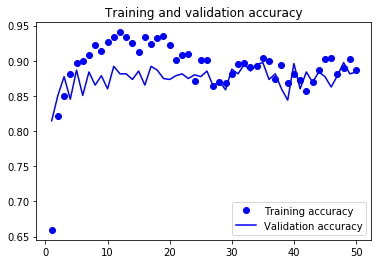

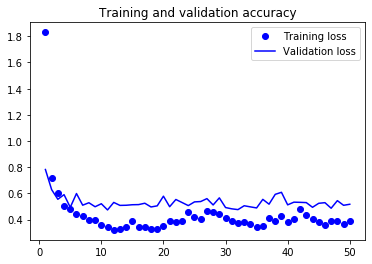

<Figure size 432x288 with 0 Axes>

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [22]:
y_pred_conf = model.predict(test_features)
y_pred = np.argmax(y_pred_conf,axis=1)

print('Accuracy score: {:.1f}%'.format(accuracy_score(y_pred,test_labels)*100))

Accuracy score: 88.4%


In [27]:
food = ['ice_cream', 'omelette', 'ramen']
print(classification_report(test_labels, y_pred, target_names=food))

              precision    recall  f1-score   support

   ice_cream       0.93      0.82      0.87       250
    omelette       0.86      0.90      0.88       250
       ramen       0.87      0.92      0.90       250

    accuracy                           0.88       750
   macro avg       0.89      0.88      0.88       750
weighted avg       0.89      0.88      0.88       750



In [73]:
def plot_confusion_matrix(cm, labels):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.yticks(tick_marks, labels, rotation=90, verticalalignment="center")
    plt.xticks(tick_marks, labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i ,j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

[[0.824 0.112 0.064]
 [0.02  0.904 0.076]
 [0.044 0.032 0.924]]


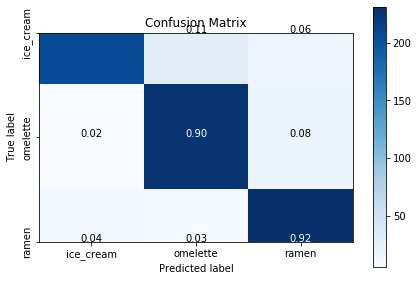

In [74]:
cm = confusion_matrix(test_labels, y_pred)
plot_confusion_matrix(cm, food)

In [40]:
model.save('food_3_classify.h5')